# Introduction

## What is this notebook?

This IPython notebook aims to provide a simple, brief analysis of the Hermina-Janos local clustering algorithm variations described and implemented at https://github.com/volfpeter/localclustering.

Before you advance, please read the descriptions of the analysed algorithms and related concepts (see https://github.com/volfpeter/localclustering/blob/master/documents/algorithm.rst) so that you are familiar with what is going to be used in this notebook.

## Notes on reproducibility

There are some things to keep in mind regarding the exact reprodicbility of previous results.

First of all, the cluster algorithms (and cluster definitions) discussed here are deterministic (as you might have noticed from their descriptions), so given the same data - i.e. a graph with exactly the same nodes and edges - and starting parameters the algorithms will produce the same results every time, unless some major changes are introduced between the used software versions.

Another important thing is that the Spotify related artists data - that is used in this notebook - is neither static nor undirected, although the used graph implementation treats it as if it was undirected or more precisely converts the directed data into undirected data. Not being static has the consequence that the neighbors of a node could change over time and that will obviously have an effect on the calculated clusters. The artist similarity data not being undirected/symmetric can be more of a problem. Imagine that there are two artists named A and B where A is similar to some artists but not similar to B and B is similar to some artists including A. In this case if we look at the neighbors of A before the neighbors of B are loaded from Spotify, then we will see that A is not a neighbor of B, but once we look at the neighbors of B as well, then we will see that A and B are neighbors. This problem can be amended - if one would like to amend it - by always starting the clustering with an empty database, although in this case the graph implementation's caching feature becomes less useful.

## Software requirements

You will need the following software to be installed in order to run the whole notebook:
  - Python 3 (https://www.python.org/) with the following libraries:
    - requests: `pip install requests`
    - sqlalchemy: `pip install sqlalchemy`
    - cairo: see https://www.cairographics.org/download/
    - pycairo: Python binding for cairo, see https://www.cairographics.org/pycairo/
    - igraph: see http://igraph.org/
    - python-igraph: igraph's Python binding, `pip install python-igraph`
    - matplotlib: chart plotting library, see https://matplotlib.org/
    - graphscraper: `pip install graphscraper`
    - localclustering: `pip install localclustering`

## Other requirements

You will need a Spotify web API client key and ID that you can obtain here: https://developer.spotify.com/web-api/.

# Preparations

This section contains the configuration that is required to run the notebook and some helper methods that will be used.

### 1) Mandatory configuration

The configuration options you will find in this section must be set to valid values for the notebook to be executable.

In [129]:
# -- Spotify web API settings.
# The client ID and key to use to connect to the Spotify web API.
SPOTIFY_CLIENT_ID = ""
SPOTIFY_CLIENT_KEY = ""

### 2) Optional settings

You can override the settings that are in this section to configure various graph or visualization settings.

In [119]:
# -- Graph configuration.
# The number of neighbors to load from the Spotify API for a given node.
NEIGHBORS_TO_LOAD_PER_NODE = 6

# -- Graph visualization settings.
NODE_COLOR_CLUSTER = "#F44336"
NODE_COLOR_DEFAULT = "#3F51B5"
NODE_COLOR_NEIGHBOR = "#2196F3"
NODE_COLOR_SOURCE = "#C62828"
NODE_SHAPE_CLUSTER = "circle"
NODE_SHAPE_DEFAULT = "circle"
NODE_SHAPE_NEIGHBOR = "circle"
NODE_SHAPE_SOURCE = "diamond"
NODE_SIZE_CLUSTER = 15
NODE_SIZE_DEFAULT = 12
NODE_SIZE_NEIGHBOR = 10
NODE_SIZE_SOURCE = 20

### 3) Helper methods

This section contains various helper methods that will be used during the analysis of the clustering algorithms.

If you are not interested in how the various outputs are generated, then just execute the cells and move on to
the more interesting parts of the notebook.

In [107]:
# Python standard library imports.
from operator import attrgetter

# IPython imports.
from IPython.display import HTML
from IPython.display import display

# igraph import.
import igraph

# pyplot import.
from matplotlib import pyplot

# Import the graph implementation that will be used to analyse the local clustering algorithms.
from graphscraper.spotifyartist import SpotifyArtistGraph

# Import the cluster algorithm implementations and the required related components.
from localclustering.cluster import Cluster
from localclustering.definitions.connectivity import ConnectivityClusterDefinition
from localclustering.hierarchicalengine import HierarchicalClusterEngine
from localclustering.localengine import LocalClusterEngine

In [50]:
def get_nodes_in_alphabetical_order(cluster):
    """Returns the nodes in and around the cluster in alphabetical order."""
    nodes = []
    nodes.extend(cluster.nodes)
    nodes.extend(cluster.neighborhood)
    nodes.sort(key=attrgetter("name"))
    return nodes

In [61]:
def get_nodes_ordered_in_cluster_rank_name_order(cluster, rank_provider):
    """
    Returns the nodes of the cluster ordered by 1) whether they are in the cluster
    2) by their rank 3) by their label.
    """
    nodes = []
    nodes.extend(rank_provider.sort_nodes_by_rank(cluster.nodes))
    nodes.extend(rank_provider.sort_nodes_by_rank(cluster.neighborhood))
    return nodes

In [17]:
def convert_cluster_to_graph(cluster):
    """Converts the given cluster into an igraph graph instance."""
    # Collect all the nodes that should be present in the igraph graph.
    nodes = get_nodes_in_alphabetical_order(cluster)
    
    # Create the graph.
    graph = igraph.Graph(n=len(nodes))
    
    # Set node properties.
    vs = graph.vs
    for i, node in enumerate(nodes):
        vs[i]["name"] = node.name
        
    # Add edges.
    for node in nodes:
        for neighbor in node.neighbors:
            # Don't add edges twice.
            if neighbor.name < node.name:
                continue
            
            try:
                graph.add_edge(node.name, neighbor.name)
            except ValueError:
                # New nodes might have been loaded during the node.neighbors call.
                # We must handle these cases gently.
                pass
    
    return graph

In [28]:
def create_empty_graph_database(db_id, clean_database=False):
    """Creates an empty SQLite graph database and returns the database interface for the graph to use."""
    # SQLAlchemy imports - SQLAlchemy will be used under the hood to interact with the actual SQLite database.
    import sqlalchemy
    from sqlalchemy.ext.declarative import declarative_base
    from sqlalchemy.orm import sessionmaker
    from sqlalchemy.pool import StaticPool
    
    # Import the method that will create the database interface the graph will use.
    from graphscraper.db import create_graph_database_interface

    # Prepare the SQLAlchemy components.
    Base = declarative_base()
    engine = sqlalchemy.create_engine("sqlite:///cluster-analysis-database-{}.db".format(db_id), poolclass=StaticPool)
    Session = sessionmaker(bind=engine)
    
    # Create the database interface the graph implementation needs.
    database = create_graph_database_interface(sqlalchemy, Session(), Base, sqlalchemy.orm.relationship)
    
    # Remove every data from the database if it is required.
    if clean_database:
        Base.metadata.drop_all(engine)
    Base.metadata.create_all(engine)
    
    return database

In [29]:
def create_new_graph_with_clean_database(db_id, clean_database=False):
    """Creates a new graph instance."""
    return SpotifyArtistGraph(
        SPOTIFY_CLIENT_ID,
        SPOTIFY_CLIENT_KEY,
        NEIGHBORS_TO_LOAD_PER_NODE,
        create_empty_graph_database(db_id, clean_database)
    )

In [116]:
def plot_cluster(source_nodes, cluster, rank_provider):
    """Plots the result of the clustering using igraph."""
    graph = convert_cluster_to_graph(cluster)
    nodes = get_nodes_in_alphabetical_order(cluster)
    
    colors = []
    labels = []
    shapes = []
    sizes = []
    
    for node in nodes:
        labels.append(node.name)
        if cluster.is_source_node(node):
            colors.append(NODE_COLOR_SOURCE)
            shapes.append(NODE_SHAPE_SOURCE)
            sizes.append(NODE_SIZE_SOURCE)
        elif node in cluster:
            colors.append(NODE_COLOR_CLUSTER)
            shapes.append(NODE_SHAPE_CLUSTER)
            sizes.append(NODE_SIZE_CLUSTER)
        elif cluster.is_neighbor(node):
            colors.append(NODE_COLOR_NEIGHBOR)
            shapes.append(NODE_SHAPE_NEIGHBOR)
            sizes.append(NODE_SIZE_NEIGHBOR)
        else:
            colors.append(NODE_COLOR_DEFAULT)
            shapes.append(NODE_SHAPE_DEFAULT)
            sizes.append(NODE_SIZE_DEFAULT)
    
    display(igraph.plot(
        graph,
        layout=graph.layout("kk"),
        vertex_color=colors,
        vertex_label=labels,
        vertex_shape=shapes,
        vertex_size=sizes
    ))

In [127]:
def plot_rank_chart(cluster, rank_provider, threshold):
    """Plots the rank chart of the given cluster."""
    nodes = get_nodes_ordered_in_cluster_rank_name_order(cluster, rank_provider)
    ranks = rank_provider.get_rank_for_nodes(nodes)
    names = ["* {}".format(node.name) if cluster.is_source_node(node) else node.name for node in nodes]
    number_of_artists = len(nodes)
    _ = pyplot.figure(dpi=160)
    pyplot.scatter(range(number_of_artists), ranks)
    pyplot.xticks(range(number_of_artists), names, rotation=90)
    pyplot.axvline(len(cluster) - 0.5, color="yellow")
    pyplot.axhline(threshold, color="red")
    pyplot.xlabel("Artists")
    pyplot.ylabel("Rank")
    pyplot.show()

In [114]:
def plot_result_as_table(source_nodes, cluster, rank_provider, threshold):
    """Prints the result of a clustering in a formatted table."""
    # Get the nodes within the cluster sorted by their rank.
    nodes_in_cluster = rank_provider.sort_nodes_by_rank(cluster.nodes)
    # Get the nodes in the neighborhood of the cluster sorted by their rank.
    nodes_in_neighborhood = rank_provider.sort_nodes_by_rank(cluster.neighborhood)
    
    index = 0
    
    table = ["<table>", "<caption>Cluster and neighborhood details</caption>"]
    
    # Add the table header.
    table.append(
        "<thead><tr><th></th><th>{}</th><th>{}</th><th>{}</th><th>Note</th></tr></thead>".format(
            "Source?", "Artist", "Rank"
        )
    )
    
    # Start adding table's body.
    table.append("<tbody>")
    
    # Print the results as a table.
    for node in nodes_in_cluster:
        rank = rank_provider.get_node_rank(node)
        index += 1
        table.append("<tr><td>{}</td><td>{:<}</td><td><b>{}</b></td><td>{:.4f}</td><td>{}</td></tr>".format(
            index, "Yes" if node in source_nodes else "", node.name, rank,
            "  <= below threshold, it should be a source node" if rank < threshold else ""
        ))
    
    # Print the results as a table.
    for node in nodes_in_neighborhood:
        rank = rank_provider.get_node_rank(node)
        index += 1
        table.append("<tr><td>{}</td><td></td><td>{}</td><td>{:.4f}</td><td>{}</td></tr>".format(
            index, node.name, rank,
            "  <= above threshold, should be in cluster" if rank > threshold else ""
        ))
        
    # Close the table body and the table.
    table.append("</tbody>")
    table.append("</table>")
    display(HTML("\n".join(table)))

# Analysis of the Hermina-Janos local clustering algorithm

This section provides a brief analysis of the implementation of the Hermina-Janos local clustering algorithm using the Spotify artist graph.

Please keep in mind that the execution of the cells below can take a significant amount of time because of the number of API requests and database updates that need to be done if the required data has not been downloaded already.

## Preparations

First of all the graph the cluster analysis is executed on and the clustering algorithm must be created and configured.

In [9]:
# Create the graph to execute the clustering algorithm on.
graph = create_new_graph_with_clean_database("local")

# Prepare the cluster definition to use.
weighting_coefficient = 2
threshold_modifier = 0.85
cluster_definition = ConnectivityClusterDefinition(weighting_coefficient, threshold_modifier)

# Create and configure the local cluster engine to use.
local_cluster_engine = LocalClusterEngine(
    ConnectivityClusterDefinition(),  # Use the connectivity based cluster definition.
    source_nodes_in_result=True,  # Ensure that source nodes are not removed from the cluster.
    max_cluster_size=75  # Specify an upper limit for the calculated cluster's size.
)

## Clustering

In the subsections of this section we will execute and analyse the local clustering algorithm on various parts of the Spotify artist graph, some of which are easier while others are harder to cluster.

### 1) Elvis Presley - An easy case

Cluster:


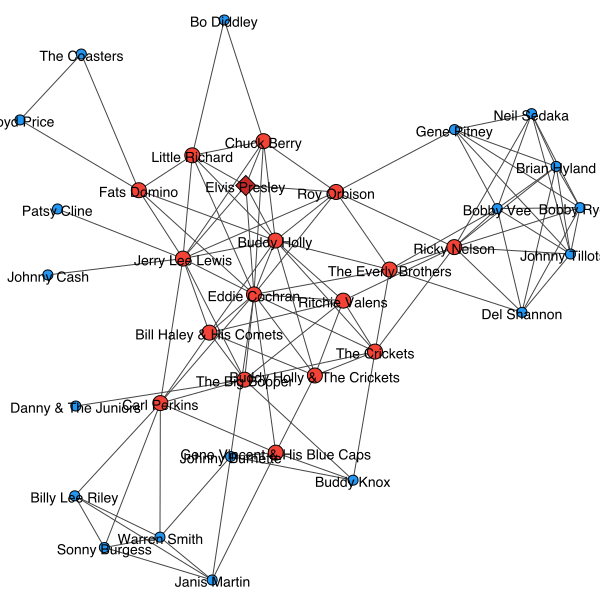



Cluster and neighborhood details:


,Source?,Artist,Rank,Note
1,,Eddie Cochran,8.5106,
2,,Buddy Holly,6.8085,
3,,Jerry Lee Lewis,5.6738,
4,,Bill Haley & His Comets,4.7059,
5,,Buddy Holly & The Crickets,4.7059,
6,Yes,Elvis Presley,4.7059,
7,,Ritchie Valens,4.7059,
8,,Roy Orbison,4.1176,
9,,The Crickets,4.1176,
10,,Chuck Berry,4.0336,




Rank chart:


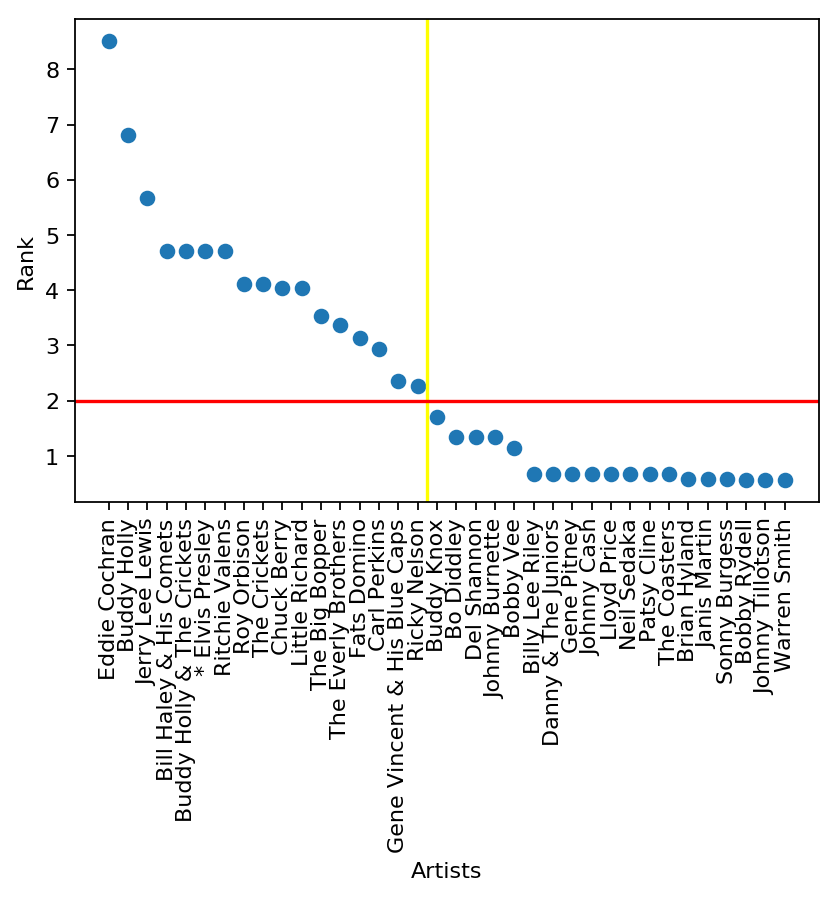

In [128]:
# Find the node that represents the artist in the graph.
artist_node = graph.nodes.get_node_by_name("Elvis Presley", can_validate_and_load=True)
if artist_node is None:
    raise ValueError("Node couldn't be loaded. Probably either there is a connection "
                     "problem with the Spotify API. Make sure your internet connection "
                     "is working and you have set a correct Spotify client ID and key pair.")

# Specify the source nodes for the clustering.
source_nodes = [artist_node]

# Execute the clustering.
local_cluster_engine.cluster_definition = cluster_definition
cluster = local_cluster_engine.cluster(source_nodes)

# Construct a rank provider for the clustering that was just executed.
rank_provider = local_cluster_engine.get_rank_provider()

# Plot the cluster and print it as a table as well.
# Notice that display() must be used for the plot to be visible,
# otherwise only the second output will be visible.
print("Cluster:")
plot_cluster(source_nodes, cluster, rank_provider)
print("\n\nCluster and neighborhood details:")
plot_result_as_table(source_nodes, cluster, rank_provider, weighting_coefficient)
print("\n\nRank chart:")
plot_rank_chart(cluster, rank_provider, weighting_coefficient)

#### 1.1) Context

Since this is the first analysed case, let's start with giving some context to the visualized data.

The first image shows the cluster in the form of an undirected graph that contains only the artists that are either i) within the cluster or ii) in the immediate neighborhood of the cluster. This is important because it implies that for the neighboring nodes of the cluster only those edges will be visible that connect them either to the neighborhood of the cluster or to the cluster itself, edges going outwards are not shown. While it might seem like data or context is being neglected, this approach actually improves the visibility of the most relevant information: the relation of the cluster with its neighborhood - don't forget how local cluster analysis works.

The cluster and neighborhood details table lists the nodes that are in the cluster or in the cluster's neighborhood along with their rank and some notes if they are required for some reason. The names of the nodes within the cluster are highlighted with bold text and the source node or nodes of the cluster analysis are marked in the corresponding column.

Finally the rank chart shows the nodes - on the horizontal axis - that are in the cluster or in its neighborhood and their rank on the vertical axis. The chart is divided into 4 areas by a red and a yellow line. The red line represents the threshold at or above which nodes are expected to be in the cluster. The yellow line separates the nodes that are in the cluster (left side) and those that are not (right side). You might expect that all the nodes will be either in the top left or in the bottom right area of the chart, but this is not always the case. Nodes may end up in the bottom left area if they should not be in the cluster but the clustering algorithm is not allowed to remove them from the cluster because they are source nodes (the origin) of the cluster. Occasionally the top right area will also contain some nodes, which happens when the clustering algorithm ends in a loop at a state where it would be able to add these nodes to the cluster during the next step.

#### 1.2) Overview of the results

As can be seen from the plot, the artist is in a relatively well-defined cluster that contais all the artist's neighbors. Buddy Knox is fairly well connected to the cluster but his rank is visibly below the threshold the cluster definition defines. Also there are two densely interconnected groups of nodes in the neighborhood of the cluster, one around Del Shannon and Bobby Vee and another around Janis Martin, Sonny Burgess and Warren Smith. The nodes in these groups have quite low ranks which indicates a clear cluster boundary.

Looking at the cluster and neighborhood details table also proves that a well-defined cluster has been found: the artist with the lowest rank within the cluster still has a rank around 33% higher the the node with the highest rank outside the cluster.

The rank chart shows two interesting things: a steadily declining rank curve and large rank plateaus both inside the cluster and in its neighborhood.

# Analysis of the Hermina-Janos hierarchical local clustering algorithm

This section provides a brief analysis of the implementation of the Hermina-Janos hierarchical local clustering algorithm using the Spotify artist graph.

Please keep in mind that the execution of the cells below can take a significant amount of time (even more than in simple local clustering section) because of the number of API requests and database updates that need to be done if the required data has not been downloaded already.

## Preparations

In [11]:
# Create the graph to execute the clustering algorithm on.
graph = create_new_graph_with_clean_database("hierarchical")

# Create and configure the hierarchical cluster engine.
hierarchical_cluster_engine = HierarchicalClusterEngine()
hierarchical_cluster_engine.cluster_definition = ConnectivityClusterDefinition(
    weighting_coefficient=1.1,
    threshold_modifier=0.85
)
hierarchical_cluster_engine.min_cluster_size = 20